# RNAseq data normalization and transformation

## Jen Wisecaver 
#### 2019-09-20

This tutorial walks you through preparing a gene-level expression matrix based on transcript-level abundance estimates output from Kallisto. 

In [21]:
# Required R libraries
library(stringr)
library(tximport)
library(DESeq2)
library(dplyr)
library(ggplot2)
library(vsn)

## Step 1: Prepare input files
We will be using the [tximport](https://bioconductor.org/packages/release/bioc/html/tximport.html) bioconductor package for importing and summarizing the data from Kallisto. See this [tutorial](https://bioconductor.org/packages/release/bioc/vignettes/tximport/inst/doc/tximport.html#import-transcript-level-estimates) for additional ways to import data from different sources (e.g. Salmon or RSEM).

### Abundance files
Prepare a list of all the `abundance.h5` files that you want to include in your matrix. Include the full path to each file. Store the list in a textfile, one abundance file per line. 

In [3]:
filesfile <- 'example/abundance_files.txt'

cat(system((paste('head -n 5', filesfile)), intern=TRUE), sep='\n')

example/abundance_dir/Sample1_Condition1/abundance.tsv 
example/abundance_dir/Sample1_Condition2/abundance.tsv 
example/abundance_dir/Sample1_Condition3/abundance.tsv 
example/abundance_dir/Sample1_Condition4/abundance.tsv 
example/abundance_dir/Sample1_Condition5/abundance.tsv 


Read in the list of files and store as a list. Then assign a sample ID to each file. I find it easiest to make each Kallisto output directory the same as the sample ID. That way I can use `str_split` to get the sample IDs directly from the file list.

In [5]:
library(stringr)
files <- scan(filesfile, what = 'list')
file_names <- str_split(files, '/', simplify = TRUE)
file_names <- file_names[,ncol(file_names)-1]
names(files) <- file_names
head(files)

Sample1_Condition1 
"example/abundance_dir/Sample1_Condition1/abundance.tsv" 
                                      Sample1_Condition2 
"example/abundance_dir/Sample1_Condition2/abundance.tsv" 
                                      Sample1_Condition3 
"example/abundance_dir/Sample1_Condition3/abundance.tsv" 
                                      Sample1_Condition4 
"example/abundance_dir/Sample1_Condition4/abundance.tsv" 
                                      Sample1_Condition5 
"example/abundance_dir/Sample1_Condition5/abundance.tsv" 
                                      Sample2_Condition1 
"example/abundance_dir/Sample2_Condition1/abundance.tsv"

### Transcript-to-gene lookup table
Prepare a transcript-to-gene lookup table to pass to tximport. The table must consist of two columns with the first column containing the transcript ID and second column containing the gene ID. The column names do not matter, but the transcript ID must be the same one used in the abundance files.

In [6]:
t2gfile <- 'example/transcripts2genes.txt'

cat(system((paste('head -n 5', t2gfile)), intern=TRUE), sep='\n')

transcriptid	geneid
g0001.t1	g0001
g0002.t1	g0002
g0002.t2	g0002
g0003.t1	g0003


In [7]:
tx2gene <- read.table(t2gfile, sep="\t", header=TRUE)
head(tx2gene)

transcriptid,geneid
<fct>,<fct>
g0001.t1,g0001
g0002.t1,g0002
g0002.t2,g0002
g0003.t1,g0003
g0004.t1,g0004
g0005.t1,g0005


### Sample table
Prepare a sample table describing the experiment design. This table should include the sample ID in the first column and the experimental condition in the second. Label the second column 'condition'.

In [8]:
samplefile <- 'example/sample_conditions.txt'

cat(system((paste('head -n 5', samplefile)), intern=TRUE), sep='\n')

sample	condition
Sample1_Condition1	Condition1
Sample2_Condition1	Condition1
Sample1_Condition2	Condition2
Sample2_Condition2	Condition2


In [9]:
sampleTable <- read.table(samplefile, sep="\t", header=TRUE)
head(sampleTable)

sample,condition
<fct>,<fct>
Sample1_Condition1,Condition1
Sample2_Condition1,Condition1
Sample1_Condition2,Condition2
Sample2_Condition2,Condition2
Sample1_Condition3,Condition3
Sample2_Condition3,Condition3


## Step 2: Import and transform data
Import the abundance estimates using `tximport`. We are working with 3'tagged RNAseq in this example. Therefore set `countsFromAbundance = "no"` because these counts do not have a length bias.

In [10]:
library(tximport)
#library(rhdf5)
txi <- tximport(files, type = "kallisto", tx2gene = tx2gene, countsFromAbundance = "no")
names(txi)

Note: importing `abundance.h5` is typically faster than `abundance.tsv`
reading in files with read_tsv
1 2 3 4 5 6 7 8 9 10 
summarizing abundance
summarizing counts
summarizing length


[1] "abundance"           "counts"              "length"             
[4] "countsFromAbundance"

`tximport` returns a list of matrices: "abundance", "counts", "length", "countsFromAbundance". 

In [11]:
# raw counts (not scaled by abundances)
head(txi$counts)

,Sample1_Condition1,Sample1_Condition2,Sample1_Condition3,Sample1_Condition4,Sample1_Condition5,Sample2_Condition1,Sample2_Condition2,Sample2_Condition3,Sample2_Condition4,Sample2_Condition5
g0001,496.00000,1699.0000,918.00000,573,655.1700,271.0000,1561.00000,1340.000,805.661,1008.00000
g0002,212.84710,274.6051,201.87000,132,157.5880,348.7580,195.73800,280.302,225.000,190.57200
g0003,4.15309,10.3948,6.12971,0,14.4119,6.2423,6.26176,16.698,0.000,8.42848
g0004,26.00000,52.0000,169.00000,27,71.0000,8.0000,37.00000,69.000,82.000,82.00000
g0005,8.00000,20.0000,3.00000,11,17.0000,13.0000,16.00000,5.000,21.000,24.00000
g0006,4.00000,46.0000,14.00000,20,34.0000,4.0000,29.00000,6.000,36.000,47.00000


**If you are working with full-length RNAseq**, you should set `countsFromAbundance = "scaledTPM"`. Notice how the counts matrix changes.

In [12]:
scaledtxi <- tximport(files, type = "kallisto", tx2gene = tx2gene, countsFromAbundance = "scaledTPM")
head(scaledtxi$counts)

Note: importing `abundance.h5` is typically faster than `abundance.tsv`
reading in files with read_tsv
1 2 3 4 5 6 7 8 9 10 
summarizing abundance
summarizing counts
summarizing length


,Sample1_Condition1,Sample1_Condition2,Sample1_Condition3,Sample1_Condition4,Sample1_Condition5,Sample2_Condition1,Sample2_Condition2,Sample2_Condition3,Sample2_Condition4,Sample2_Condition5
g0001,566.889034,2208.796646,1199.758253,598.66577,821.489366,347.015595,1874.242050,1499.649261,1010.06321,1195.374630
g0002,104.519366,153.713000,114.429302,59.81578,85.700366,193.693962,101.932109,136.058084,122.34639,97.573174
g0003,1.072400,3.053147,1.809927,0.00000,4.082608,1.805896,1.698589,4.222018,0.00000,2.258197
g0004,27.408134,62.352865,203.717535,26.01863,82.109875,9.448439,40.974621,71.223857,94.82010,89.691197
g0005,20.127920,57.238178,8.631078,25.29975,46.923384,36.645017,42.289879,12.318227,57.95731,62.653979
g0006,1.104181,14.443946,4.419207,5.04692,10.296522,1.237095,8.409823,1.621816,10.90094,13.461938


### Create Expression Matrices 

Create a DESeq dataset using `DESeqDataSetFromTximport`

In [14]:
library(DESeq2)
dds <- DESeqDataSetFromTximport(txi, sampleTable, ~condition)
dds <- estimateSizeFactors(dds)

using counts and average transcript lengths from tximport
using 'avgTxLength' from assays(dds), correcting for library size


`DESeqDataSetFromTximport` will automatically round txi$counts to the nearest integer

In [15]:
head(counts(dds))

,Sample1_Condition1,Sample1_Condition2,Sample1_Condition3,Sample1_Condition4,Sample1_Condition5,Sample2_Condition1,Sample2_Condition2,Sample2_Condition3,Sample2_Condition4,Sample2_Condition5
g0001,496,1699,918,573,655,271,1561,1340,806,1008
g0002,213,275,202,132,158,349,196,280,225,191
g0003,4,10,6,0,14,6,6,17,0,8
g0004,26,52,169,27,71,8,37,69,82,82
g0005,8,20,3,11,17,13,16,5,21,24
g0006,4,46,14,20,34,4,29,6,36,47


### Remove genes with no expression
Perform only the bare minimum of filtering here to remove genes that have no expression at all. Additional filtering can be done later in the pipeline during the mutual rank calculation. 

In [16]:
nrow(dds)

[1] 5000

In [17]:
dds_filt <- dds[ rowSums(counts(dds)) > 0, ]
nrow(dds_filt)

[1] 3842

### Normalization
Normalize the counts data based on library size

In [18]:
normalized_matrix <- counts(dds_filt, normalized = TRUE)
head(normalized_matrix)

,Sample1_Condition1,Sample1_Condition2,Sample1_Condition3,Sample1_Condition4,Sample1_Condition5,Sample2_Condition1,Sample2_Condition2,Sample2_Condition3,Sample2_Condition4,Sample2_Condition5
g0001,639.883860,896.669163,763.306000,926.68986,755.63156,405.041415,1370.721609,1199.864609,758.96286,862.398908
g0002,272.787847,144.385299,168.319103,213.93398,182.66356,522.735039,172.475921,251.253153,212.32153,163.012671
g0003,5.160354,5.277629,4.988928,0.00000,16.15090,8.967707,5.268629,15.222163,0.00000,6.844436
g0004,33.542299,27.443671,140.521475,43.66601,81.90815,11.956942,32.489878,61.784073,77.21458,70.155467
g0005,10.320707,10.555258,2.494464,17.78986,19.61181,19.430031,14.049677,4.477107,19.77447,20.533307
g0006,5.160354,24.277093,11.640832,32.34520,39.22362,5.978471,25.465040,5.372528,33.89909,40.211060


### Variance stabilization
Use `vst` to create a variance stabilized matrix that controls for the fact that gene variance is not consistent across the dataset. See this helpful [tutorial](http://master.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#pre-filtering-the-dataset) for more information, including alternative methods for variance stabilization (e.g. rlog). FYI, the vst function also normalizes the matrix prior variance stabilization. 

In [19]:
vsd <- vst(dds_filt, blind = FALSE)
normalized_vst_matrix <- assay(vsd)
head(normalized_vst_matrix)

,Sample1_Condition1,Sample1_Condition2,Sample1_Condition3,Sample1_Condition4,Sample1_Condition5,Sample2_Condition1,Sample2_Condition2,Sample2_Condition3,Sample2_Condition4,Sample2_Condition5
g0001,9.376645,9.847982,9.622416,9.894237,9.608296,8.747413,10.446774,10.258364,9.614442,9.793301
g0002,8.216023,7.396980,7.589421,7.897035,7.693456,9.096820,7.620354,8.107347,7.887215,7.548934
g0003,4.559262,4.569212,4.544493,3.649179,5.208971,4.835214,4.568453,5.167283,3.649179,4.691916
g0004,5.802569,5.624868,7.363328,6.052837,6.721218,5.006923,5.773598,6.409818,6.654558,6.547906
g0005,4.916532,4.929984,4.287256,5.279038,5.352300,5.345191,5.112352,4.498674,5.358626,5.387704
g0006,4.559262,5.521785,4.990059,5.769564,5.948780,4.626291,5.561456,4.577175,5.812246,5.972620


You can vizualize the effect of the transformation two ways. The first method was taken from this [tutorial](http://master.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#pre-filtering-the-dataset).

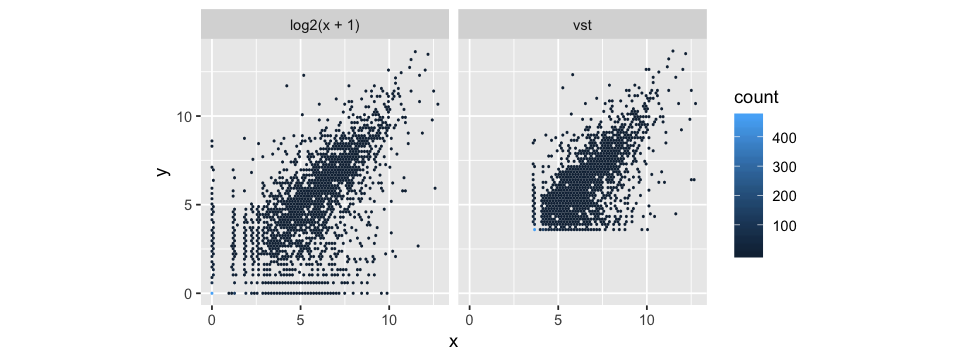

In [22]:
library(dplyr)
library(ggplot2)
options(repr.plot.width=8, repr.plot.height=3)

df <- bind_rows(as_data_frame(log2(counts(dds_filt, normalized=TRUE)[, 1:2]+1)) %>% mutate(transformation = "log2(x + 1)"), as_tibble(assay(vsd)[, 1:2]) %>% mutate(transformation = "vst"))
colnames(df)[1:2] <- c("x", "y")  
ggplot(df, aes(x = x, y = y)) + geom_hex(bins = 80) + coord_fixed() + facet_grid( . ~ transformation)

The second method was taken from this [tutorial](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#variance-stabilizing-transformation)

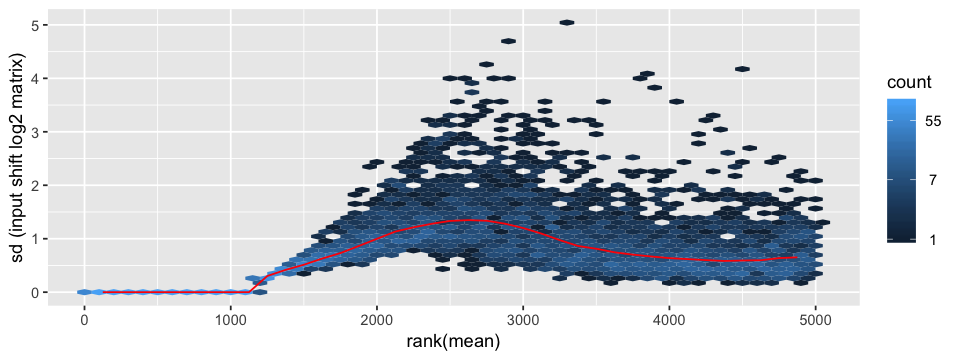

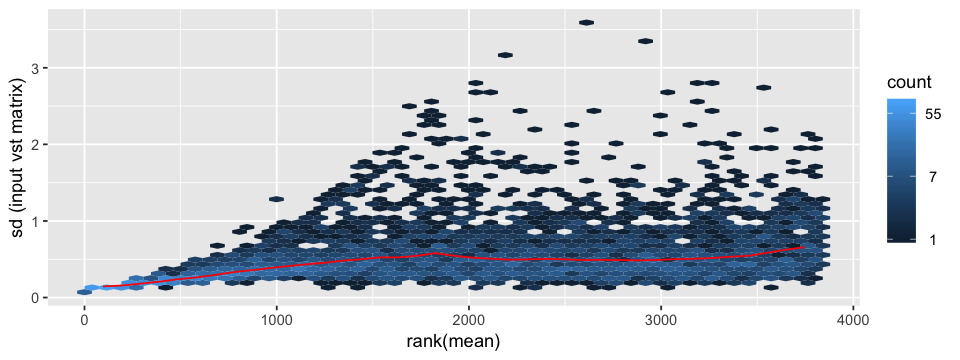

In [24]:
# this gives log2(n + 1)
ntd <- normTransform(dds)
library(vsn)
meanSdPlot(assay(ntd),ylab  = "sd (input shift log2 matrix)")
meanSdPlot(assay(vsd),ylab  = "sd (input vst matrix)")

Notice that in both plots the shifted log2 data has elevated standard deviation in the lower count range, whereas for the variance stabilized data the standard deviation is more constant along the whole dynamic range.

## Step 3: Create stats table for downstream filtering

Prior to constructing Mutual Ranks, it is often best to filter out very lowly expressed genes and/or genes that have very low variance across the analysis. I've found that the importance of filtering is inversely correlated with the number of columns (samples) in the matrix. Smaller matrices have less power and are more likely to have genes appear correlated due to artifact. In these small matricies, I often enforce stricter thresholds for minimum expression/variance.  

Here, we tabulate expression statistics for each gene in the analysis. We can use the output to select genes to exclude later, during the Mutual Rank calculation step in the pipeline.

In [25]:
# Tally number of genes with expression greater than zero
df_binary <- normalized_matrix
df_binary[df_binary == 0] <- 0
df_binary[df_binary > 0] <- 1
stats_df <- as.data.frame(rowSums(df_binary))
names(stats_df) <- c('no. samples with count > 0')

# Tally number of genes with expression greater than or equal to five
df_binary <- normalized_matrix
df_binary[df_binary < 5] <- 0
df_binary[df_binary > 0] <- 1
stats_df$'no. samples with count >= 5' = rowSums(df_binary)

# Tally number of genes with expression greater than or equal to ten
df_binary <- normalized_matrix
df_binary[df_binary < 10] <- 0
df_binary[df_binary > 0] <- 1
stats_df$'no. samples with count >= 10' = rowSums(df_binary)

# Calculate median expression genes in the normalized matrix
median_expression  <- apply(normalized_matrix, 1, median)
stats_df$'pre-VST median expression' = median_expression

# Calculate mean expression genes in the normalized matrix
mean_expression  <- apply(normalized_matrix, 1, mean)
stats_df$'pre-VST mean expression' = mean_expression

# Calculate expression variance genes in the normalized matrix
exp_variance <- apply(normalized_matrix, 1, var)
stats_df$'pre-VST expression variance' = exp_variance

# Calculate median expression genes in the VST matrix
median_expression  <- apply(normalized_vst_matrix, 1, median)
stats_df$'post-VST median expression' = median_expression

# Calculate mean expression genes in the VST matrix
mean_expression  <- apply(normalized_vst_matrix, 1, mean)
stats_df$'post-VST mean expression' = mean_expression

# Calculate expression variance genes in the VST matrix
exp_variance <- apply(normalized_vst_matrix, 1, var)
stats_df$'post-VST expression variance' = exp_variance

head(stats_df)

,no. samples with count > 0,no. samples with count >= 5,no. samples with count >= 10,pre-VST median expression,pre-VST mean expression,pre-VST expression variance,post-VST median expression,post-VST mean expression,post-VST expression variance
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
g0001,10,10,10,812.852454,857.916985,74220.94199,9.707858,9.720987,0.2185666
g0002,10,10,10,197.492548,230.388811,12190.76706,7.790335,7.905358,0.2409696
g0003,8,7,2,5.273129,6.788075,29.57587,4.568832,4.544316,0.2822476
g0004,10,10,10,52.725044,58.068256,1380.07588,6.231328,6.195762,0.4569048
g0005,10,8,8,15.919767,13.903669,44.41614,5.195695,5.046766,0.1513350
g0006,10,10,7,24.871066,22.357328,201.87448,5.541621,5.333924,0.3425973


## Step 4: Write matrices to file
That's it! Write both matrices and the stats data frame to outfiles. These outfiles will serve as input for calculating Pearson's correlation coefficients

In [26]:
norm_outfil = 'example/gene_counts_normalized.matrix'
write.table(normalized_matrix, norm_outfil, sep="\t", quote = FALSE)

normVst_outfil = 'example/gene_counts_normalized_vst_transformed.matrix'
write.table(normalized_vst_matrix, normVst_outfil, sep="\t", quote = FALSE)

stats_outfil = 'example/gene_counts_statistics.txt'
write.table(stats_df, stats_outfil, sep="\t", quote = FALSE)